In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

In [3]:
Walk = namedtuple('Walk', ['Route','Reward'])
np.random.seed =1

class walkGenerator:
    def __init__(self):
        
        #Dictionary to encode state position to a vector
        self.state_arrays = {
                'A':np.array([1,0,0,0,0,0,0]),
                'B':np.array([0,1,0,0,0,0,0]),
                'C':np.array([0,0,1,0,0,0,0]),
                'D':np.array([0,0,0,1,0,0,0]),
                'E':np.array([0,0,0,0,1,0,0]),
                'F':np.array([0,0,0,0,0,1,0]),
                'G':np.array([0,0,0,0,0,0,1])
               }
        #Possible states
        self.states = ('A','B','C','D','E','F','G')

        #state 0 (A) has a reward of 0
        #state 6 (G) has a reward of 1
        self.rewards = {0:0, 6:1}


        #End at state A or G
        self.terminal_states = (0,6)
        
    def take_a_walk(self):
        #initialize empty array to hold the walk progression
        walk = []
        #rewards for the walk
        r = []
        #Always start at position 3 (D)
        current_state = 3
        
        while True:
            #add initial state to walk
            walk.append(self.states[current_state])

            #take a random left or right walk
            action = np.random.choice([-1,1], p=[0.5,0.5])

            #update state position
            current_state = current_state + action

            #check for terminal state
            if current_state in self.terminal_states:
                walk.append(self.states[current_state])
                r.append(self.rewards[current_state])
                break
            else:
                r.append(0)
                
        state_matrix = []

        for position in walk:
            state_matrix.append(self.state_arrays[position])

        state_matrix = np.array(state_matrix)
        
        return Walk(state_matrix, r)
    
    def generate_training_sets(self, num_samples, sequences_per_sample):
        assert isinstance(num_samples, int), 'num_samples param must be integer'
        assert num_samples > 0, 'num_samples param must be greater than 0'
        assert isinstance(sequences_per_sample, int), 'sequences_per_sample param must be integer'
        assert sequences_per_sample > 0, 'sequences_per_sample param must be greater than 0'
        
        training_sets = []
        for i in range(num_samples):
            current_set = []
            for j in range(sequences_per_sample):
                
                walk = self.take_a_walk()
                current_set.append(walk)
                
            training_sets.append(current_set)
        return training_sets

In [164]:
generated_sets = walkGenerator().generate_training_sets(num_samples=100, sequences_per_sample=10)

In [86]:
def td_lambda(training_set, lamda, gamma):
    alphas=[0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    ideal = np.array([(1.0/6.0, (1.0/3.0), (1.0/2.0), (2.0/3.0), (5.0/6.0))])


    rmses = []
    for alpha in alphas:

        

        state_weights = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}
        values_per_seq = []
        global_values = [0,0.5,0.5,0.5,0.5,0.5,0]





        for sequence in training_set:

            values = global_values.copy()
            assert values == global_values, 'Initialization of state values is not feeding forward to the next episode'
            eligibility = np.zeros(7)

            walk = sequence.Route
            rewards = sequence.Reward

            for step in range(len(walk)-1):
                state = np.argmax(walk[step])
                transition = np.argmax(walk[step+1])
                eligibility[state] +=1
                update = rewards[step] + gamma*values[transition] - values[state]
                for pos, val in enumerate(values):
                    state_weights[pos].append( alpha * update * eligibility[pos] )
                    eligibility[pos] = eligibility[pos] * lamda * gamma

            for k in state_weights.keys():
                weights_summed = np.sum(state_weights[k])
                global_values[k] = global_values[k] + weights_summed
            
            state_weights = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}
            
        rmse = np.sqrt(np.mean((global_values[1:-1]-ideal)**2))
        rmses.append(rmse)
        
            
            
            







    return rmses

In [75]:



test = [Walk(Route=np.array([[0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0],
                   
                             [0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 1]
                   ]), Reward=[0, 0, 0, 0, 0, 0, 1])]

In [76]:
td_lambda(test, 0.3, gamma=1)

[0.23570226039551584,
 0.2204326895722578,
 0.21335478545767186,
 0.2066996593971655,
 0.2005094132047284,
 0.19482836355133215,
 0.18970226297032108,
 0.1851772037255582,
 0.1812981959500926,
 0.1781074557717468,
 0.17564249662253303,
 0.17393417809531733]

In [96]:
zero = []
three = []
eight = []
one = []

for i in range(len(generated_sets)):
    vs8 =td_lambda(generated_sets[i], lamda=0.8, gamma=1)
    vs1 =td_lambda(generated_sets[i], lamda=1.0, gamma=1)
    vs3 = td_lambda(generated_sets[i], lamda=0.3, gamma=1)
    vs0 = td_lambda(generated_sets[i], lamda=0.0, gamma=1)
    
    eight.append(vs8)
    one.append(vs1)
    three.append(vs3)
    zero.append(vs0)
    
zero = np.mean(zero, axis=0)
three = np.mean(three, axis=0)
eight = np.mean(eight, axis=0)
one = np.mean(one, axis=0)

In [97]:
alphas = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

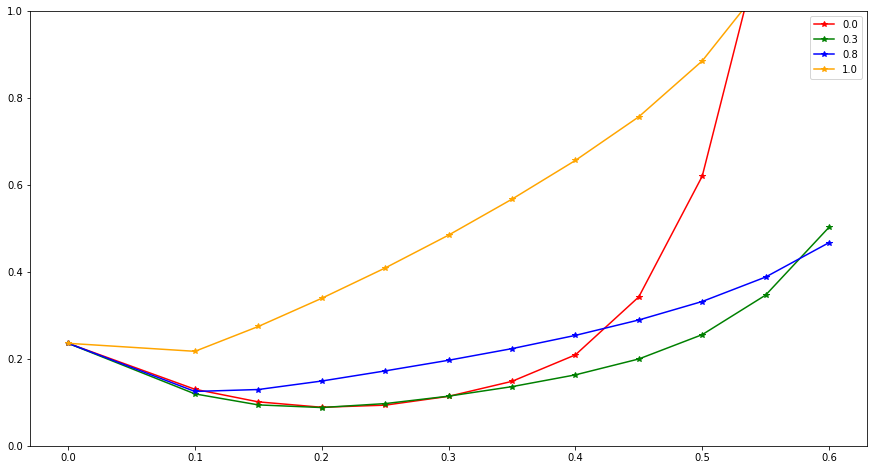

In [98]:
plt.figure(figsize=(15,8))
plt.plot(alphas, zero, color='red', marker='*', label = '0.0')
plt.plot(alphas, three, color='green', marker='*', label = '0.3')
plt.plot(alphas, eight, color='blue', marker='*', label= '0.8')
plt.plot(alphas, one, color='orange', marker='*', label='1.0')
plt.ylim(0,1.0)
plt.legend()
plt.show()

In [ ]:
vs0

In [165]:
def experiment_1(training_set, alpha, gamma=1):
    lamdas=[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    ideal = np.array([(1.0/6.0, (1.0/3.0), (1.0/2.0), (2.0/3.0), (5.0/6.0))], dtype='float64')


    rmses =[]
    for lamda in lamdas:

        

        

        global_values = np.zeros(7, dtype='float64')
        temp_global_values = np.zeros(7, dtype='float64')
        converged = False

        while not converged:

            state_weights = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}

            for sequence in training_set:

                values = global_values.copy()

                eligibility = np.zeros(7, dtype='float64')

                walk = sequence.Route
                rewards = sequence.Reward

                for step in range(len(walk)-1):
                    state = np.argmax(walk[step])
                    transition = np.argmax(walk[step+1])
                    eligibility[state] +=1
                    update = rewards[step] + (gamma*values[transition] - values[state])
                    for pos, val in enumerate(values):
                        state_weights[pos].append(alpha * update * eligibility[pos])
                        eligibility[pos] = eligibility[pos] * lamda * gamma

            #print(global_values, '\n\n')
            for key, values in state_weights.items():
                #print(values)
                summed_weights = np.sum(values)
                temp_global_values[key] = temp_global_values[key] + summed_weights
              
            diff = np.abs(temp_global_values - global_values)

            if all(diff <= 0.001):
                converged = True
            global_values = temp_global_values.copy()

        rmse = np.sqrt(np.mean((global_values[1:-1]-ideal)**2, dtype='float64'))

        rmses.append(rmse)
    return(rmses)

In [166]:
rmse = []
for i in range(100):

    r = experiment_1(generated_sets[i], alpha=0.01)
    
    rmse.append(r)

In [167]:
r = np.mean(rmse, axis=0)

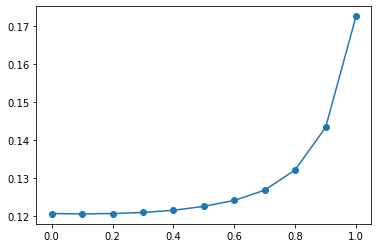

In [168]:
plt.figure()
plt.plot([0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], r, marker='o')
plt.show()